In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i - seq_length:i])  
        y.append(scaled_data[i, -1])  

    return np.array(X), np.array(y), scaler




In [2]:
# Load dataset using datasets library
from datasets import load_dataset
dataset = load_dataset("Ammok/apple_stock_price_from_1980-2021")

data = np.column_stack((
    dataset['train']['Open'],
    dataset['train']['High'],
    dataset['train']['Low'],
    dataset['train']['Volume'],
    dataset['train']['Close']
))

seq_length = 120 
X, y, scaler = preprocess_data(data, seq_length)

# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)



In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, num_layers=3, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply hidden_dim by 2 for bidirectional
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output of the last time step
        return out

# Instantiate the model
model = LSTMModel(input_dim=5)  # All features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)







In [4]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val).item()

    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.15f}, Validation Loss: {val_loss:.4f}")


Epoch 1/50, Train Loss: 0.000556417714418, Validation Loss: 0.0257
Epoch 2/50, Train Loss: 0.000015046893689, Validation Loss: 0.0206
Epoch 3/50, Train Loss: 0.000011798974754, Validation Loss: 0.0230
Epoch 4/50, Train Loss: 0.000010224888281, Validation Loss: 0.0257
Epoch 5/50, Train Loss: 0.000008257670453, Validation Loss: 0.0261
Epoch 6/50, Train Loss: 0.000007364288912, Validation Loss: 0.0291
Epoch 7/50, Train Loss: 0.000006718870051, Validation Loss: 0.0276
Epoch 8/50, Train Loss: 0.000005851745776, Validation Loss: 0.0255
Epoch 9/50, Train Loss: 0.000005259112586, Validation Loss: 0.0262
Epoch 10/50, Train Loss: 0.000004839701271, Validation Loss: 0.0261
Epoch 11/50, Train Loss: 0.000004673153476, Validation Loss: 0.0270
Epoch 12/50, Train Loss: 0.000004208666412, Validation Loss: 0.0289
Epoch 13/50, Train Loss: 0.000004086202815, Validation Loss: 0.0329
Epoch 14/50, Train Loss: 0.000003805808358, Validation Loss: 0.0290
Epoch 15/50, Train Loss: 0.000003292318769, Validation Lo

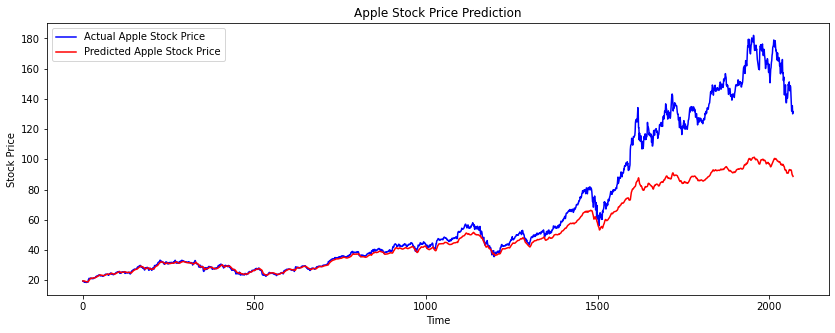

RMSE: 25.45, MAE: 13.81


In [5]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)

        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten predictions and actuals
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Inverse transform predictions and actuals
predicted_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(predictions), 4)), predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(actuals), 4)), actuals]))[:, -1]

# Plot the predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(real_prices, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print RMSE and MAE for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mae = mean_absolute_error(real_prices, predicted_prices)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Inverse transform predictions and actuals
predicted_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(predictions), 4)), predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(actuals), 4)), actuals]))[:, -1]

mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 12.05%


C:\Users\Yuning\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/50, Train Loss: 0.000428588, Validation Loss: 0.0006
Epoch 2/50, Train Loss: 0.000004786, Validation Loss: 0.0012
Epoch 3/50, Train Loss: 0.000002255, Validation Loss: 0.0003
Epoch 4/50, Train Loss: 0.000002088, Validation Loss: 0.0006
Epoch 5/50, Train Loss: 0.000001804, Validation Loss: 0.0013
Epoch 6/50, Train Loss: 0.000001741, Validation Loss: 0.0023
Epoch 7/50, Train Loss: 0.000001732, Validation Loss: 0.0029
Epoch 8/50, Train Loss: 0.000001607, Validation Loss: 0.0026
Epoch 9/50, Train Loss: 0.000001753, Validation Loss: 0.0031
Epoch 10/50, Train Loss: 0.000001715, Validation Loss: 0.0035
Epoch 11/50, Train Loss: 0.000001578, Validation Loss: 0.0035
Epoch 12/50, Train Loss: 0.000001450, Validation Loss: 0.0030
Epoch 13/50, Train Loss: 0.000001515, Validation Loss: 0.0033
Epoch 14/50, Train Loss: 0.000001471, Validation Loss: 0.0030
Epoch 15/50, Train Loss: 0.000001485, Validation Loss: 0.0032
Epoch 16/50, Train Loss: 0.000001409, Validation Loss: 0.0034
Epoch 17/50, Trai

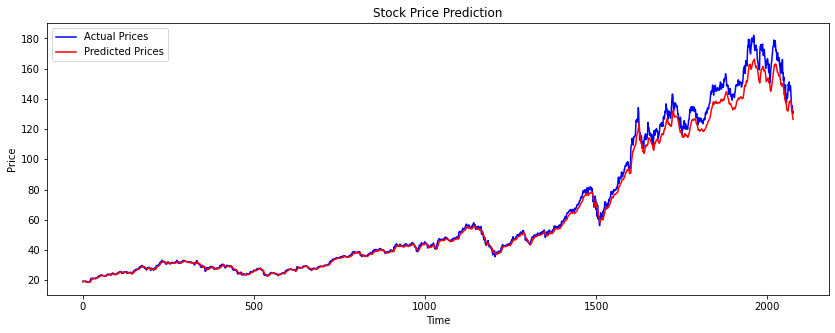

(4.802479296867648, 2.769755200927749, 3.0517303260977164)

In [7]:

# Preprocessing function
def preprocess_data(data, seq_length=90):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i - seq_length:i])
        y.append(scaled_data[i, -1])  # Predicting the 'Close' price

    return np.array(X), np.array(y), scaler

# Load the dataset
dataset = load_dataset("Ammok/apple_stock_price_from_1980-2021")
data = np.column_stack((
    dataset['train']['Open'],
    dataset['train']['High'],
    dataset['train']['Low'],
    dataset['train']['Volume'],
    dataset['train']['Close']
))

# Hyperparameters from Trial 1
seq_length = 90
hidden_dim = 256
num_layers = 1
dropout = 0.5
lr = 0.01
batch_size = 64
num_epochs = 50

# Preprocess the data
X, y, scaler = preprocess_data(data, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoaders for batching
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=256, num_layers=1, output_dim=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional, so multiply hidden_dim by 2

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Get output of the last time step
        return out

# Instantiate and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.9f}, Validation Loss: {val_losses[-1]:.4f}")

# Evaluate the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten predictions and actuals
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Inverse transform predictions and actuals
predicted_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(predictions), 4)), predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(actuals), 4)), actuals]))[:, -1]

# Calculate RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mae = mean_absolute_error(real_prices, predicted_prices)
mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100

# Plot predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(real_prices, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

rmse, mae, mape
